# Learn PrimeKG embeddings

In [ ]:
from pykeen.hpo import hpo_pipeline
from pykeen.datasets import PrimeKG

# model used to learn the embeddings 
model_used = ['TransE','DistMult','ConvE','ComplEx','RotatE']

for model in model_used:

    hpo_pipeline_result = hpo_pipeline(

        n_trials=10,
        dataset=PrimeKG(random_state = 127),
        model='TransE',
        model_kwargs=dict(embedding_dim=200, entity_initializer="xavier_uniform"),

        optimizer='Adam',
        optimizer_kwargs=dict(type=float, low=0.0001, high=0.01, log=False),
        training_loop='slcwa',
        training_kwargs=dict(num_epochs=100, batch_size=1024),

        negative_sampler='basic',
        negative_sampler_kwargs=dict(num_negs_per_pos=1),
        evaluator_kwargs=dict(filtered=True),
        evaluation_kwargs=dict(batch_size=64),

        stopper='early',
        stopper_kwargs=dict(frequency=5, patience=2, relative_delta=0.01)

    )

# Read pykeen results, extract embeddings and dimensionality reduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import torch

In [3]:
def read_model_return_embeddings(model_path, dataset):

    trained_best_model = torch.load(model_path)

    entity_representation_modules: List['pykeen.nn.Representation'] = trained_best_model.entity_representations
    relation_representation_modules: List['pykeen.nn.Representation'] = trained_best_model.relation_representations

    entity_embeddings: pykeen.nn.Embedding = entity_representation_modules[0]
    relation_embeddings: pykeen.nn.Embedding = relation_representation_modules[0]

    entity_embedding_tensor: torch.FloatTensor = entity_embeddings().detach().cpu()
    relation_embedding_tensor: torch.FloatTensor = relation_embeddings().detach().cpu()

    entity_to_id = dataset.entity_to_id
    relation_to_id = dataset.relation_to_id

    return trained_best_model, entity_embedding_tensor, relation_embedding_tensor, entity_to_id, relation_to_id

In [4]:
# read PrimeKG node files
nodes = pd.read_csv("../nodes.csv")

# define the path with the results
results_path = "./"

TransE_trials = pd.read_csv(results_path + '/TransE/200/hpo_results/trials.tsv', sep="\t")
ConvE_trials = pd.read_csv(results_path + '/ConvE/200/hpo_results/trials.tsv', sep="\t")
DistMult_trials = pd.read_csv(results_path + '/DistMult/200/hpo_results/trials.tsv', sep="\t")
ComplEX_trials = pd.read_csv(results_path + '/ComplEX/200/hpo_results/trials.tsv', sep="\t")
RotatE_trials = pd.read_csv(results_path + '/RotatE/200/hpo_results/trials.tsv', sep="\t")

# best trials
best_TransE_trials = TransE_trials.iloc[TransE_trials['value'].idxmax()]
best_ConvE_trials = ConvE_trials.iloc[ConvE_trials['value'].idxmax()]
best_DistMult_trials = DistMult_trials.iloc[DistMult_trials['value'].idxmax()]
best_ComplEX_trials = ComplEX_trials.iloc[ComplEX_trials['value'].idxmax()]
best_RotatE_trials = RotatE_trials.iloc[RotatE_trials['value'].idxmax()]

# read the best model saved

# TransE
best_TransE_path = results_path + '/TransE/200/best_model/replicates/replicate-00000/trained_model.pkl'
best_TransE_model, best_TransE_embeddings_entities, best_TransE_embeddings_relations, entity_to_id, relation_to_id = read_model_return_embeddings(best_TransE_path, PrimeKG())

# DistMult
best_DistMult_path = results_path + '/DistMult/200/best_model/replicates/replicate-00000/trained_model.pkl'
best_DistMult_model, best_DistMult_embeddings_entities, best_DistMult_embeddings_relations, entity_to_id, relation_to_id = read_model_return_embeddings(best_DistMult_path, PrimeKG())

# ComplEX
best_ComplEX_path = results_path + '/ComplEX/200/best_model/replicates/replicate-00000/trained_model.pkl'
best_ComplEX_model, best_ComplEX_embeddings_entities, best_ComplEX_embeddings_relations, entity_to_id, relation_to_id = read_model_return_embeddings(best_ComplEX_path, PrimeKG())

# RotatE
best_RotatE_path = results_path + '/RotatE/200/best_model/replicates/replicate-00000/trained_model.pkl'
best_RotatE_model, best_RotatE_embeddings_entities, best_RotatE_embeddings_relations, entity_to_id, relation_to_id = read_model_return_embeddings(best_RotatE_path, PrimeKG())

# ConvE
best_ConvE_path = results_path + '/ConvE/200/best_model/replicates/replicate-00000/trained_model.pkl'
best_ConvE_model, best_ConvE_embeddings_entities, best_ConvE_embeddings_relations, entity_to_id, relation_to_id = read_model_return_embeddings(best_ConvE_path, PrimeKG())


In [5]:
# define node df
node_df = pd.DataFrame.from_dict({'node_name': list(entity_to_id.keys()),'Node ID': list(entity_to_id.values())})
node_df = node_df.merge(nodes[['node_name','node_type']],on='node_name',how="left")
node_more_type = list(node_df['node_name'].value_counts()[node_df['node_name'].value_counts().values>1].index)


In [31]:
import umap
def dimensionality_reduction_KG_embeddings( best_model_embeddings_entities, node_df_tofill):

    # create the UMAP object
    d2_umap = umap.UMAP(n_components=2, min_dist=0.25, n_neighbors=25)

    node_df = node_df_tofill.copy(True)

    # make the dimensionality reduction

    # complex number
    if best_model_embeddings_entities.dtype == torch.complex64:
        entities_embedding_tensor_umap2D = d2_umap.fit_transform(torch.concatenate([torch.real(best_model_embeddings_entities),torch.imag(best_model_embeddings_entities)],axis=1))
    else:

        entities_embedding_tensor_umap2D = d2_umap.fit_transform(best_model_embeddings_entities)
    entities_embedding_tensor_umap2D_df = pd.DataFrame(entities_embedding_tensor_umap2D)



    # fill nodedf with the 2D dimension and node type color
    dimension0 = []
    dimension1 = []
    node_type_color = []

    for index,row in node_df.iterrows():

        dimension0.append(entities_embedding_tensor_umap2D_df.iloc[row['Node ID']][0])
        dimension1.append(entities_embedding_tensor_umap2D_df.iloc[row['Node ID']][1])

        if row['node_name'] in node_more_type:
            node_type_color.append(True)

        else:
            node_type_color.append(False)

    node_df['UMAP 1'] = dimension0
    node_df['UMAP 2'] = dimension1
    node_df['node_type_color'] = node_type_color


    return node_df



In [49]:
RotatE_entities_embedding_2D_df = dimensionality_reduction_KG_embeddings(best_RotatE_embeddings_entities, node_df)

In [ ]:
#RotatE
RotatE_entities_embedding_2D_df['node_type'] = RotatE_entities_embedding_2D_df['node_type'].replace({'biological_process':'biological process',
                                                     'cellular_component':'cellular component',
                                                     'molecular_function':'molecular function'})

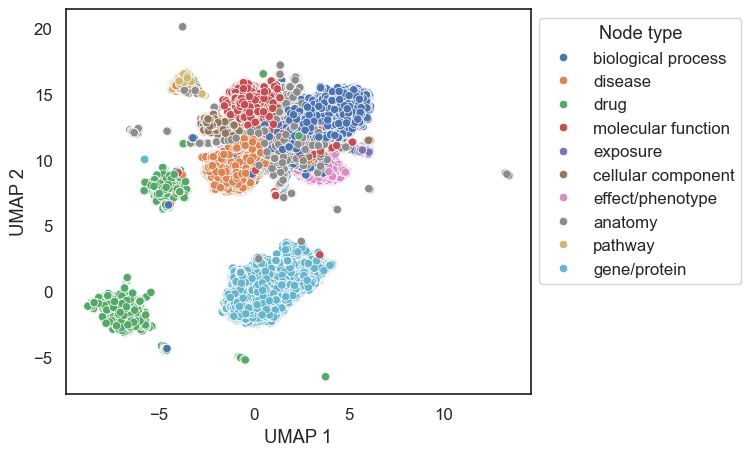

In [73]:


plt.figure(figsize=(6,5))
sb.set_theme(style="white", font_scale=1.1)
aa = sb.scatterplot(data=RotatE_entities_embedding_2D_df[RotatE_entities_embedding_2D_df['node_type_color']==False], x='UMAP 1', y='UMAP 2', hue='node_type')
plt.legend(title='Node type')
sb.move_legend(aa, "upper left", bbox_to_anchor=(1, 1))
plt.savefig("./RotatE_embeddings.png",bbox_inches='tight',dpi=500)